In [1]:
!which python

/scratch/smp/uqsmac12/.conda/env/lit_torch_gp/bin/python


WHERE IS THE DATA: 'Q2051'

In [63]:
import os
import numpy as np
import pandas as pd

from anndata import read_h5ad

import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torch import optim, nn, utils, Tensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torchvision.io import read_image

# from torchvision.transforms import ToTensor
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [62]:
# update the location where models will be saved to
if torch.hub.get_dir() == '/clusterdata/uqsmac12/.cache/torch/hub':
    torch.hub.set_dir('/scratch/smp/uqsmac12/.cache/torch/hub')

In [ ]:
# setup new conda environment

# load data

# implement somthing similar to STimage1

# test likelihood assumption with log [CPT] data transform
# test likelihood assumption without transform

# load data

In [6]:
torch.cuda.is_available()

True

In [7]:
DIR_DATA = '/scratch/smp/uqsmac12/stimage2_data'
DIR_CHECKPOINTS = os.path.join(DIR_DATA, 'checkpoints')
DIR_WANDB = DIR_DATA

In [8]:
DIR_TILES = '/scratch/smp/uqsmac12/dataset_breast_cancer_9visium'
DIR_ANNDATA_PROCESSED = '/scratch/smp/uqsmac12/dataset_breast_cancer_9visium'
file_processed_alex_data = 'all_adata.h5ad'
# DIR_PROCESSED_DATA = '/afm03/Q2/Q2051/STimage_project/STimage_dataset/PROCESSED/dataset_breast_cancer_9visium'

In [9]:
adata_all = read_h5ad(os.path.join(DIR_ANNDATA_PROCESSED, file_processed_alex_data))

In [10]:
# update metadata for annadata such that it maps to the correct location
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(
    lambda x: x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium",
                        DIR_TILES))

In [11]:
assert 'uqsmac12' in adata_all.obs['tile_path'][0]

In [12]:
gene_list = ["COX6C","TTLL12", "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN", "SPARC", "CD74", "CD63", "CD24", "CD81"]

The gene expressions, $X$, are log transformed, hence $\exp(X)\sim\text{NegativeBinomial}(.)$

In [13]:
adata_all.shape

(24578, 14664)

Get counts

In [14]:
def logX_to_counts(X):
    return np.exp(X).round(0).astype(int)

In [15]:
def counts_to_cpm(X):
    lib_size = X.sum(axis=1).reshape(-1,1)
    X = X * 1e6 / lib_size
    return X

log (cpm) appears best... why it doesn't get used is a bit of a mystery.

In [ ]:
x_counts = np.exp(adata_all[:,'COX6C'].to_df().values.reshape(-1))
plt.hist(x_counts, bins=100, label='x')
plt.legend()
plt.show()
plt.hist(np.log(x_counts), bins=100, label='log(x)')
plt.legend()
plt.show()

In [108]:
# dataset_train.adata.obs_names
dataset_train.adata.obs.loc['TATGGGACCGAGCAGG-1-1142243F', 'tile_path']

'/scratch/smp/uqsmac12/dataset_breast_cancer_9visium/tiles/1142243F-19778-12811-299.jpeg'

In [110]:
dataset_train.adata.obs['library_id'].unique()

['1142243F', 'block2', '1160920F', 'block1', 'CID4535', 'CID4290', 'CID44971', 'CID4465']
Categories (8, object): ['1142243F', '1160920F', 'CID4290', 'CID4465', 'CID44971', 'CID4535', 'block1', 'block2']

In [25]:
class STimageDataset(Dataset):
    '''
    Note that the `transform` and `target_transform` arguments can be used to 
    adjust the target variables as needed.
    '''
    def __init__(self, adata, genes=None, transform=None, target_transform=None):
        self.adata = adata
        self.genes = genes
        self.num_genes = len(genes)
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        
        return int(self.adata.n_obs)
    
    def __getitem__(self, idx):
        idx_name = adata_all.obs_names[idx]
        X_img = self.load_img(idx_name)
        y = self.get_expression(idx_name)
        
        return X_img, y
    
    def load_img(self, key):
        """load an image"""
        img_path = self.adata.obs.loc[key, 'tile_path']
        X_img = read_image(img_path)
            
        if self.transform:
            X_img = self.transform(X_img)
        
        return X_img
    
    def get_expression(self, key):
        y = torch.Tensor(adata_all[idx_name, gene_list].to_df().values)
        
        if self.target_transform:
            y = self.target_transform(y)
        
        return y

# split train, val, test datasets

In [74]:
# test_categories = ["FFPE", "1160920F"]
test_categories = ['FFPE']

In [75]:
adata_all.shape

(24578, 14664)

In [76]:
adata_dev = adata_all[~adata_all.obs['library_id'].isin(test_categories)]
adata_dev.shape

(22240, 14664)

In [77]:
adata_test = adata_all[adata_all.obs['library_id'].isin(test_categories)]
adata_test.shape

(2338, 14664)

In [91]:
# get train 
validation_split = 0.2

indices = list(adata_dev.obs_names)

np.random.shuffle(indices)
dataset_size = len(indices)

split_loc = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split_loc:], indices[:split_loc]
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

adata_train = adata_dev[train_indices,:]
adata_val = adata_dev[val_indices,:]

In [96]:
dataset_train = STimageDataset(adata_train, genes=gene_list)
dataset_val = STimageDataset(adata_val, genes=gene_list)
dataset_test = STimageDataset(adata_test, genes=gene_list)

In [94]:
len(dataset_train)

17792

In [95]:
len(dataset_val)

4448

In [97]:
len(dataset_test)

2338

# dataloader

In [99]:
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=64, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=64, shuffle=False)

# train pretrained resnet

# Pytorch module

In [31]:
os.environ['TORCH_HOME']

KeyError: 'TORCH_HOME'

# lit module

In [102]:
import torchvision

'/clusterdata/uqsmac12/.cache/torch/hub'

In [35]:
torch.hub.set_dir('/scratch/smp/uqsmac12/.cache/torch/hub')

In [36]:
torch.hub.get_dir()

'/scratch/smp/uqsmac12/.cache/torch/hub'

In [103]:
class ImagenetTransferLearning(pl.LightningModule):
    def __init__(self):
        super().__init__(output_dim, pretrained_model=None)
        
        if not pretrained_model:
            backbone = torchvision.models.resnet18(weights="DEFAULT")
        else:
            raise NotImplementedError("requires testing and planning")
            backbone = pretrained_model
            
        num_filters = backbone.fc.in_features
        layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*layers)
        
        # use the pretrained model
        self.regession = nn.Linear(num_filters, output_dim)
        
    def forward(self, x):
        self.feature_extractor.eval()
        
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.regression(representations)

In [104]:
# finetune
model = ImagenetTransferLearning()

In [112]:
for param in model.children():
    print(param.requires_grad)

AttributeError: 'Sequential' object has no attribute 'requires_grad'

In [117]:
param[0].

<bound method Module.requires_grad_ of Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)>

In [ ]:

trainer = Trainer()
trainer.fit(model)

In [ ]:
def create_model():
    model = torchvision.models.resnet18(pretrained=False, num_classes=10)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.maxpool = nn.Identity()
    return model

In [ ]:
# # use to predict data of interest
# model = ImagenetTransferLearning.load_from_checkpoint(PATH)
# model.freeze()

# x = some_images_from_cifar10()
# predictions = model(x)

In [ ]:
class LitAutoEncoder(pl.LightningModule):
    """
    Lightning module is full recipe defining how modules interact
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder 
        self.decoder = decoder
        
        self.save_hyperparameters(ignore=['encoder', 'decoder']) # 'gives model attribute 'hyper_parameters'

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
        x = x.view(x.size(0), -1) # reshape since autoencoder is mlp
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        if trainer.global_step == 0:
            wandb.define_metric('val_loss', summary='min')
        # this is the validation loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = F.mse_loss(x_hat, x)
        self.log("val_loss", val_loss) # what is monitored
    
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = F.mse_loss(x_hat, x)
        self.log("test_loss", test_loss)

    def configure_optimizers(self, lr=1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        return optimizer

# logger

In [ ]:
wandb_logger = WandbLogger(
    project="Stimage2", 
    log_model="all",
    save_dir=DIR_WANDB,
    name='stimage1_likelihood_sensitivity' # run names
)

# dataset

In [ ]:
# # dataset
# train_set = MNIST(root=DIR_DATA, download=True, transform=transforms.ToTensor())
# test_set = MNIST(root=DIR_DATA, download=True, train=False, transform=transforms.ToTensor())

# # use 20% of training data for validation
# train_set_size = int(len(train_set) * 0.8)
# valid_set_size = len(train_set) - train_set_size

# # split the train set into two
# seed = torch.Generator().manual_seed(42)
# train_set, valid_set = random_split(train_set, [train_set_size, valid_set_size], generator=seed)

# # dataloaders
# train_loader = DataLoader(train_set, batch_size=256, num_workers=8)
# valid_loader = DataLoader(valid_set, batch_size=256, num_workers=8)
# test_loader = DataLoader(test_set, batch_size=256, num_workers=8)

# trainer


In [ ]:
# train model
early_stopping_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3,)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath=None, monitor="val_loss", save_top_k=1, every_n_epochs=None
)

trainer = pl.Trainer(
    default_root_dir=DIR_CHECKPOINTS, 
    enable_checkpointing=True, 
    accelerator='gpu', 
    logger=wandb_logger,
    callbacks=[early_stopping_callback],
    
)

trainer.fit(model=autoencoder, train_dataloaders=train_loader, val_dataloaders=valid_loader)

# SUPERSEDED

## SEE notebook `stimage1_basic_expression_vis`

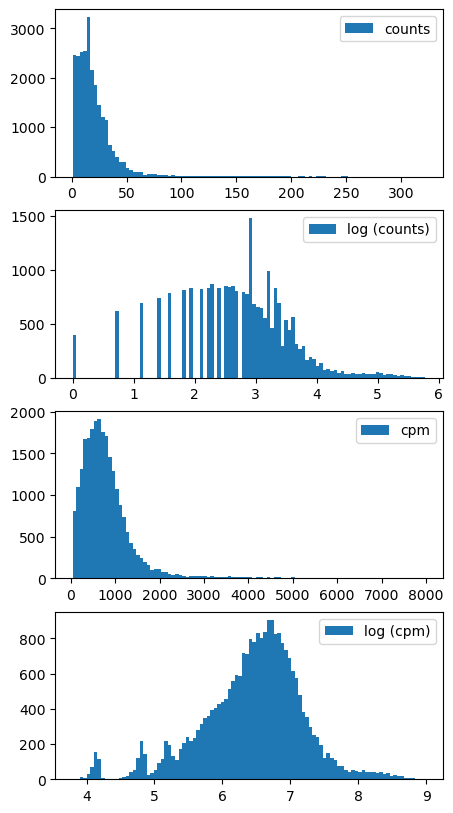

In [123]:
gene = 'PABPC1'

x_cpm = df_X_cpm[gene].values.reshape(-1)

x_counts = np.exp(adata_all[:,gene].to_df().values.reshape(-1)).round(0).astype(int)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5,10))
ax[0].hist(x_counts, bins=100, label='counts')
ax[0].legend()
ax[1].hist(np.log(x_counts), bins=100, label='log (counts)')
ax[1].legend()
ax[2].hist(x_cpm, bins=100, label='cpm')
ax[2].legend()
ax[3].hist(np.log(x_cpm), bins=100, label='log (cpm)')
ax[3].legend()
fig.show()

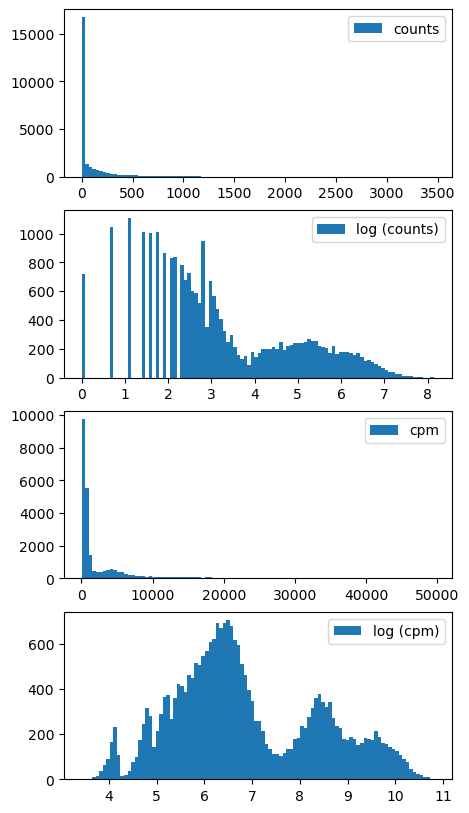

In [121]:
gene = 'COX6C'

x_cpm = df_X_cpm[gene].values.reshape(-1)

x_counts = np.exp(adata_all[:,gene].to_df().values.reshape(-1)).round(0).astype(int)

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(5,10))
ax[0].hist(x_counts, bins=100, label='counts')
ax[0].legend()
ax[1].hist(np.log(x_counts), bins=100, label='log (counts)')
ax[1].legend()
ax[2].hist(x_cpm, bins=100, label='cpm')
ax[2].legend()
ax[3].hist(np.log(x_cpm), bins=100, label='log (cpm)')
ax[3].legend()
fig.show()